In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Load cleaned dataset (Member 1's output)
cleaned_data = pd.read_csv("01.cleaned_telco_customer_data.csv")
print("Loaded cleaned data:", cleaned_data.shape)

# Work on a copy for integration
df = cleaned_data.copy()
df.head()


Loaded cleaned data: (60175, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST00001,Male,0,No,Yes,3.0428,Yes,Yes,No,No,...,No,No,No,No,Month-to-month,No,Mailed check,71.907980,99.810180,Yes
1,CUST00002,Male,1,Yes,No,3.0428,Yes,Yes,DSL,No,...,No,Yes,Unknown,No,One year,Yes,Bank transfer (automatic),21.351177,99.810180,No
2,CUST00003,Female,0,No,No,36.8700,Yes,Yes,DSL,No,...,No,Unknown,Yes,Yes,Month-to-month,No,Electronic check,41.157794,1727.307038,Yes
3,CUST00005,Male,1,Yes,Yes,14.1083,Yes,Unknown,Fiber optic,Yes,...,Yes,No,No,No,Two year,Yes,Electronic check,21.351177,324.789382,Yes
4,CUST00006,Male,0,Yes,No,20.0413,Yes,No,Fiber optic,No,...,Unknown,Yes,Unknown,No,One year,No,Electronic check,34.567089,556.898661,Yes


 1) Schema normalization (strings trimmed, numeric coercion)

In [ ]:

print("Before normalization dtypes:\n", df.dtypes.head(12))

# Trim whitespace on object columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str).str.strip()

# Ensure numeric columns are numeric
numeric_cols = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("\nAfter normalization dtypes:\n", df.dtypes[numeric_cols])


Before normalization dtypes:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
dtype: object

After normalization dtypes:
 SeniorCitizen       int64
tenure            float64
MonthlyCharges    float64
TotalCharges      float64
dtype: object


2) Entity identification: detect near-duplicate customerIDs and similar names

In [14]:
df = df.drop_duplicates(subset=["customerID"], keep="first").reset_index(drop=True)
print("Duplicates removed. Shape:", df.shape)

Duplicates removed. Shape: (60175, 21)


3) Value conflict resolution for Charges

In [24]:
# 3. Resolve TotalCharges conflicts (vectorized)
if set(["MonthlyCharges","tenure","TotalCharges"]).issubset(df.columns):
    derived = (df["MonthlyCharges"] * df["tenure"]).round(2)
    diff = (df["TotalCharges"] - derived).abs()
    conflict_mask = diff > np.maximum(1.0, 0.02 * derived)
    print("TotalCharges conflicts found:", conflict_mask.sum())

    # Correct by averaging existing and derived
    df.loc[conflict_mask, "TotalCharges"] = (
        (df.loc[conflict_mask, "TotalCharges"] + derived[conflict_mask]) / 2
    )


TotalCharges conflicts found: 53344


4) Service logic: if InternetService == "No" -> set online/streaming/tech fields to "No"

In [25]:
# 4. Service logic correction (vectorized)
if "InternetService" in df.columns:
    related = [c for c in df.columns if any(x in c.lower() for x in ["online","stream","device","techsupport"])]
    mask_no_internet = df["InternetService"].str.lower().isin(["no", "none", "no internet service"])
    for c in related:
        df.loc[mask_no_internet, c] = "No"
print("Service conflicts resolved.")


Service conflicts resolved.


5) Redundancy detection: correlation matrix, heatmap, drop very-highly-correlated (>0.98)

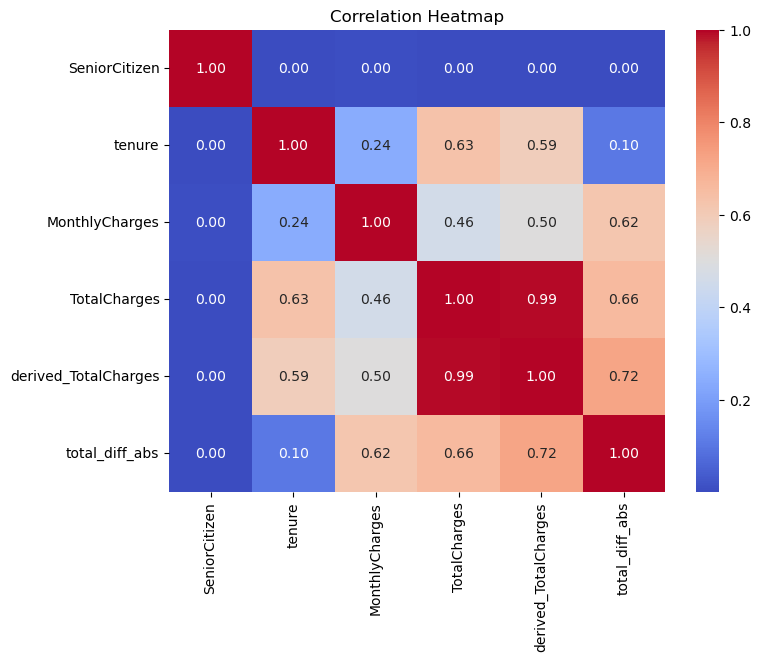

Dropped redundant columns: ['derived_TotalCharges']


In [26]:
# 5. Redundancy detection via correlation
num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] >= 2:
    corr = num_df.corr().abs()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()

    # Drop redundant (>0.98 correlation)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [c for c in upper.columns if any(upper[c] > 0.98)]
    df = df.drop(columns=to_drop)
    print("Dropped redundant columns:", to_drop)


In [27]:
# 6) Final schema enforcement & cleanup, show head, save final integrated dataset

# Ensure categorical fields are strings and numeric fields floats
for c in df.columns:
    if c == 'tenure':
        # If tenure values are all integers, convert to Int64, else keep as float
        if (df[c].dropna() == df[c].dropna().astype(int)).all():
            df[c] = pd.to_numeric(df[c], errors='coerce').astype('Int64')
        else:
            df[c] = pd.to_numeric(df[c], errors='coerce').astype(float)
    elif df[c].dtype == object:
        df[c] = df[c].astype(str)
    elif pd.api.types.is_integer_dtype(df[c]) or pd.api.types.is_float_dtype(df[c]):
        df[c] = pd.to_numeric(df[c], errors='coerce').astype(float)

# Keep derived_TotalCharges if you want audit info, else drop:
# df = df.drop(columns=['derived_TotalCharges', 'total_diff_abs', 'total_conflict'], errors='ignore')


In [28]:

# Drop helper normalization column if you don't want it saved
if 'name_norm' in df.columns:
    df = df.drop(columns=['name_norm'])


In [29]:
print("Final dataframe shape:", df.shape)
display(df.head())

Final dataframe shape: (60175, 23)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,total_diff_abs,total_conflict
0,CUST00001,Male,0.0,No,Yes,3.0428,Yes,Yes,No,No,...,No,No,Month-to-month,No,Mailed check,71.907980,189.052945,Yes,118.991420,True
1,CUST00002,Male,1.0,Yes,No,3.0428,Yes,Yes,DSL,No,...,Unknown,No,One year,Yes,Bank transfer (automatic),21.351177,73.679395,No,34.842780,True
2,CUST00003,Female,0.0,No,No,36.8700,Yes,Yes,DSL,No,...,Yes,Yes,Month-to-month,No,Electronic check,41.157794,1569.943735,Yes,209.819138,True
3,CUST00005,Male,1.0,Yes,Yes,14.1083,Yes,Unknown,Fiber optic,Yes,...,No,No,Two year,Yes,Electronic check,21.351177,307.119546,Yes,23.560582,True
4,CUST00006,Male,0.0,Yes,No,20.0413,Yes,No,Fiber optic,No,...,Unknown,No,One year,No,Electronic check,34.567089,658.802015,Yes,135.870739,True


In [30]:
# Save integrated file with exact filename requested
out_path = "02.integrated_telco_data.csv"
df.to_csv(out_path, index=False)
print(f"Integrated dataset saved as: {out_path}")


Integrated dataset saved as: 02.integrated_telco_data.csv
